# CXR-ML-GZSL

## Overview

The goal of this notebook is to reproduce the findings of the paper, "Multi-Label Generalized Zero Shot Learning for the Classification of Disease in Chest Radiographs" using the provided code.

* Paper: https://arxiv.org/abs/2107.06563
* Code: https://github.com/nyuad-cai/CXR-ML-GZSL/

The provided code is four years old, and `conda` could no longer build the provided `environment.yml`, so some changes were needed to resolve errors. Additionally, I cleaned up some imports, whitespace, filenames, etc. and adapted the code for a Jupyter notebook. However, my goal was to use the code as is in most cases.

In [10]:
import argparse
from datetime import datetime, timedelta
import glob
import hashlib
import os
import requests
import sys
import tarfile
import time
import urllib.request
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import table
from PIL import Image
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.nn.functional import kl_div, softmax, log_softmax
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms

## Environment

I used [Google Colab](https://colab.research.google.com/) to run this notebook. I had to use the paid version, as the free version does not provide enough RAM or a powerful enough GPU.

In [11]:
!python --version
!echo
!pip list | grep -E "matplotlib|numpy|pandas|pillow|sklearn|tqdm|torch|torchvision" | grep -v -E "geopandas"
!echo
!nvidia-smi

Python 3.11.12

matplotlib                         3.10.0
matplotlib-inline                  0.1.7
matplotlib-venn                    1.1.2
numpy                              2.0.2
pandas                             2.2.2
pandas-datareader                  0.10.0
pandas-gbq                         0.28.0
pandas-stubs                       2.2.2.240909
pillow                             11.1.0
sklearn-compat                     0.1.3
sklearn-pandas                     2.2.0
torch                              2.6.0+cu124
torchaudio                         2.6.0+cu124
torchsummary                       1.5.1
torchvision                        0.21.0+cu124
tqdm                               4.67.1

Thu Apr 10 18:30:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+------------

## Dataset

The paper used a dataset developed by another paper, initially known as `ChestX-ray8`, but then renamed to `ChestX-ray14` when the dataset was expanded from eight to fourteen distinct disease labels.

* Paper: https://arxiv.org/abs/1705.02315
* Dataset: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345

**Note**: The dataset is over 42 GB, which takes 20+ minutes to download to session storage. Be aware that session storage is wiped for each new session, including runtime changes like switching to a GPU.

In [12]:
ROOT_PATH = 'CXR-ML-GZSL'

if not os.path.exists(ROOT_PATH):
    os.mkdir(ROOT_PATH)

In [13]:
SAVE_PATH = f'{ROOT_PATH}/checkpoints'

if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

WEIGHTS_NAME = 'pretrained_checkpoint.pth.tar'
WEIGHTS_PATH = f'{SAVE_PATH}/{WEIGHTS_NAME}'

if not os.path.exists(WEIGHTS_PATH):
    response = requests.get('https://drive.google.com/uc?export=download&id=17ioJMW3qNx1Ktmr-hXn-eqp431cm49Rm')
    with open(WEIGHTS_PATH, 'wb') as f:
        f.write(response.content)
    print("Downloaded pretrained weights")
else:
    print("Using existing pretrained weights")

Downloaded pretrained weights


In [14]:
SPLITS_PATH = f'{ROOT_PATH}/dataset_splits'

if not os.path.exists(SPLITS_PATH):
    os.mkdir(SPLITS_PATH)

for split in ['train.txt', 'test.txt', 'val.txt']:
    if os.path.exists(f'{SPLITS_PATH}/{split}'):
        print(f"Using existing {split} dataset split file")
    else:
        response = requests.get(f"https://raw.githubusercontent.com/nyuad-cai/CXR-ML-GZSL/master/dataset_splits/{split}")
        with open(f'{SPLITS_PATH}/{split}', "wb") as file:
            file.write(response.content)
        print(f"Downloaded {split} dataset split file")

Downloaded train.txt dataset split file
Downloaded test.txt dataset split file
Downloaded val.txt dataset split file


In [15]:
EMBEDDINGS_PATH = f'{ROOT_PATH}/embeddings'

if not os.path.exists(EMBEDDINGS_PATH):
    os.mkdir(EMBEDDINGS_PATH)

BIOBERT_PATH = f'{EMBEDDINGS_PATH}/nih_chest_xray_biobert.npy'

if not os.path.exists(BIOBERT_PATH):
    response = requests.get(f"https://raw.githubusercontent.com/nyuad-cai/CXR-ML-GZSL/master/embeddings/nih_chest_xray_biobert.npy")
    with open(BIOBERT_PATH, "wb") as file:
        file.write(response.content)
    print("Downloaded text embeddings")
else:
    print("Using existing text embeddings")

Downloaded text embeddings


In [28]:
DATA_PATH = f'{ROOT_PATH}/data'

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

ENTRY_PATH = f'{DATA_PATH}/Data_Entry_2017_v2020.csv'

if os.path.isfile(ENTRY_PATH):
    print("Using existing data entry file")
else:
    response = requests.get('https://drive.google.com/uc?export=download&id=1mkOZNfYt-Px52b8CJZJANNbM3ULUVO3f')
    with open(ENTRY_PATH, "wb") as file:
        file.write(response.content)
    print("Downloaded data entry file")

Downloaded data entry file


In [17]:
IMAGE_PATH = f'{DATA_PATH}/images'

if os.path.exists(IMAGE_PATH):
    print("Using existing image data")
else:
    # Credit: https://nihcc.app.box.com/v/ChestXray-NIHCC/file/371647823217
    links = [
        'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
        'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
        'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
        'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
        'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
        'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
        'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
        'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
        'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
        'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
        'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
        'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
    ]

    # Credit: https://nihcc.app.box.com/v/ChestXray-NIHCC/file/249502714403
    md5_checksums = [
        'fe8ed0a6961412fddcbb3603c11b3698',
        'ab07a2d7cbe6f65ddd97b4ed7bde10bf',
        '2301d03bde4c246388bad3876965d574',
        '9f1b7f5aae01b13f4bc8e2c44a4b8ef6',
        '1861f3cd0ef7734df8104f2b0309023b',
        '456b53a8b351afd92a35bc41444c58c8',
        '1075121ea20a137b87f290d6a4a5965e',
        'b61f34cec3aa69f295fbb593cbd9d443',
        '442a3caa61ae9b64e61c561294d1e183',
        '09ec81c4c31e32858ad8cf965c494b74',
        '499aefc67207a5a97692424cf5dbeed5',
        'dc9fda1757c2de0032b63347a7d2895c'
    ]

    for idx, link in enumerate(links):
        fn = os.path.join(DATA_PATH, 'images_%02d.tar.gz' % (idx + 1))

        print(f'Downloading {fn}...')
        urllib.request.urlretrieve(link, fn)

        print(f"Checking MD5 checksum for {fn}...")
        with open(fn, 'rb') as f:
            file_md5 = hashlib.md5(f.read()).hexdigest()

        assert file_md5 == md5_checksums[idx], "Invalid MD5 checksum"

        print(f"Extracting {fn}...")
        with tarfile.open(fn, 'r:gz') as tar:
            tar.extractall(path=DATA_PATH)

        print(f"Deleting {fn}...")
        os.remove(fn)

    assert len([f for f in os.listdir(IMAGE_PATH) if os.path.isfile(os.path.join(IMAGE_PATH, f))]) == 112120, "Dataset is not the expected size!"
    print("Downloaded image data")

Checking MD5 checksum for CXR-ML-GZSL/data/images_01.tar.gz...
Extracting CXR-ML-GZSL/data/images_01.tar.gz...
Deleting CXR-ML-GZSL/data/images_01.tar.gz...
Checking MD5 checksum for CXR-ML-GZSL/data/images_02.tar.gz...
Extracting CXR-ML-GZSL/data/images_02.tar.gz...
Deleting CXR-ML-GZSL/data/images_02.tar.gz...
Checking MD5 checksum for CXR-ML-GZSL/data/images_03.tar.gz...
Extracting CXR-ML-GZSL/data/images_03.tar.gz...
Deleting CXR-ML-GZSL/data/images_03.tar.gz...
Checking MD5 checksum for CXR-ML-GZSL/data/images_04.tar.gz...
Extracting CXR-ML-GZSL/data/images_04.tar.gz...
Deleting CXR-ML-GZSL/data/images_04.tar.gz...
Checking MD5 checksum for CXR-ML-GZSL/data/images_05.tar.gz...
Extracting CXR-ML-GZSL/data/images_05.tar.gz...
Deleting CXR-ML-GZSL/data/images_05.tar.gz...
Checking MD5 checksum for CXR-ML-GZSL/data/images_06.tar.gz...
Extracting CXR-ML-GZSL/data/images_06.tar.gz...
Deleting CXR-ML-GZSL/data/images_06.tar.gz...
Checking MD5 checksum for CXR-ML-GZSL/data/images_07.tar.g

## Model

### KLDivLoss

In [18]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/loss.py

class KLDivLoss(nn.Module):
    def __init__(self, temperature=0.2):
        super(KLDivLoss, self).__init__()

        self.temperature = temperature

    def forward(self, emb1, emb2):
        emb1 = softmax(emb1/self.temperature, dim=1).detach()
        emb2 = log_softmax(emb2/self.temperature, dim=1)
        loss_kldiv = kl_div(emb2, emb1, reduction='none')
        loss_kldiv = torch.sum(loss_kldiv, dim=1)
        loss_kldiv = torch.mean(loss_kldiv)

        return loss_kldiv

### RankingLoss

In [19]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/loss.py

class RankingLoss(nn.Module):
    def __init__(self, neg_penalty=0.03):
        super(RankingLoss, self).__init__()

        self.neg_penalty = neg_penalty

    def forward(self, ranks, labels, class_ids_loaded, device):
        '''
        for each correct it should be higher then the absence
        '''
        labels = labels[:, class_ids_loaded]
        ranks_loaded = ranks[:, class_ids_loaded]
        neg_labels = 1+(labels*-1)
        loss_rank = torch.zeros(1).to(device)
        for i in range(len(labels)):
            correct = ranks_loaded[i, labels[i]==1]
            wrong = ranks_loaded[i, neg_labels[i]==1]
            correct = correct.reshape((-1, 1)).repeat((1, len(wrong)))
            wrong = wrong.repeat(len(correct)).reshape(len(correct), -1)
            image_level_penalty = ((self.neg_penalty+wrong) - correct)
            image_level_penalty[image_level_penalty<0]=0
            loss_rank += image_level_penalty.sum()
        loss_rank /=len(labels)

        return loss_rank

### CosineLoss

In [20]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/loss.py

class CosineLoss(nn.Module):
    def forward(self, t_emb, v_emb ):
        a_norm = v_emb / v_emb.norm(dim=1)[:, None]
        b_norm = t_emb / t_emb.norm(dim=1)[:, None]
        loss = 1 - torch.mean(torch.diagonal(torch.mm(a_norm, b_norm.t()), 0))

        return loss

### ZSLNet

In [21]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/zsl_models.py

class ZSLNet(nn.Module):
    def __init__(self, args, textual_embeddings=None, device='cpu'):
        super(ZSLNet, self).__init__()
        self.args = args
        self.device = device
        self.vision_backbone = getattr(torchvision.models, self.args.vision_backbone)(pretrained=self.args.pretrained)
        # remove classification layer from visual encoder
        classifiers = [ 'classifier', 'fc']
        for classifier in classifiers:
            cls_layer = getattr(self.vision_backbone, classifier, None)
            if cls_layer is None:
                continue
            d_visual = cls_layer.in_features
            setattr(self.vision_backbone, classifier, nn.Identity(d_visual))
            break

        pretrained_encoder = False
        if pretrained_encoder:
            self.vision_backbone.classifier = nn.Identity(d_visual)

            path = 'checkpoints/bce_only_imagenet/last_epoch_checkpoint.pth.tar'

            self.classifier = nn.Sequential(nn.Linear(d_visual, self.args.num_classes), nn.Sigmoid())
            checkpoint = torch.load(path, weights_only=False)
            self.load_state_dict(checkpoint['state_dict'])

            for p in self.vision_backbone.parameters():
                p.requires_grad = False

        if self.args.bce_only:
            self.bce_loss = torch.nn.BCELoss(size_average=True)
            self.classifier = nn.Sequential(nn.Linear(d_visual, self.args.num_classes), nn.Sigmoid())
        else:
            self.emb_loss = CosineLoss()
            self.ranking_loss = RankingLoss(neg_penalty=self.args.neg_penalty)
            self.textual_embeddings = textual_embeddings
            d_textual = self.textual_embeddings.shape[-1]

            self.textual_embeddings = torch.from_numpy(self.textual_embeddings).to(self.device)

            self.fc_v = nn.Sequential(
                nn.Linear(d_visual, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
            )

            self.fc_t = nn.Sequential(
                nn.Linear(d_textual, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 128)
            )

    def forward(self, x, labels=None, epoch=0, n_crops=0, bs=16):
        if self.args.bce_only:
            return self.forward_bce_only(x, labels=labels, n_crops=n_crops, bs=bs)
        else:
            return self.forward_ranking(x, labels=labels, epoch=epoch, n_crops=n_crops, bs=bs)

    def forward_bce_only(self, x, labels=None, n_crops=0, bs=16):
        lossvalue_bce = torch.zeros(1).to(self.device)

        visual_feats = self.vision_backbone(x)
        preds = self.classifier(visual_feats)

        if labels is not None:
            lossvalue_bce = self.bce_loss(preds, labels)

        return preds, lossvalue_bce, f'bce:\t {lossvalue_bce.item():0.4f}'

    def forward_ranking(self, x, labels=None, epoch=0, n_crops=0, bs=16):
        loss_rank = torch.zeros(1).to(self.device)
        loss_allignment_cos = torch.zeros(1).to(self.device)
        loss_mapping_consistency = torch.zeros(1).to(self.device)

        visual_feats = self.vision_backbone(x)
        visual_feats = self.fc_v(visual_feats)
        text_feats = self.fc_t(self.textual_embeddings)

        if not self.args.wo_con and epoch >= 0:
            text_mapped_sim = self.sim_score(text_feats, text_feats.detach())
            text_orig_sim = self.sim_score(self.textual_embeddings, self.textual_embeddings)
            loss_mapping_consistency = torch.abs(text_orig_sim - text_mapped_sim).mean()

        if labels is not None:
            mapped_visual, mapped_text = self.map_visual_text(visual_feats, labels, text_feats)
            if mapped_visual is not None and not self.args.wo_map and epoch >= 0:
                loss_allignment_cos = self.emb_loss(mapped_text, mapped_visual)

        ranks = self.sim_score(visual_feats, text_feats)
        if n_crops > 0:
            ranks = ranks.view(bs, n_crops, -1).mean(1)

        if labels is not None:
            loss_rank = self.ranking_loss(ranks, labels, self.class_ids_loaded, self.device)
        loss_allignment_cos = (self.args.beta_map * loss_allignment_cos)
        loss_rank = (self.args.beta_rank * loss_rank)
        loss_mapping_consistency = (self.args.beta_con * loss_mapping_consistency)
        losses = loss_rank + loss_mapping_consistency + loss_allignment_cos

        return ranks, losses

    def sim_score(self, a, b):
        a_norm = a / a.norm(dim=1)[:, None]
        b_norm = b / (1e-6+b.norm(dim=1))[:, None]
        score = (torch.mm(a_norm, b_norm.t()))

        return score

    def map_visual_text(self, visual_feats, labels, labels_embd):
        mapped_labels_embd = []
        labels == 1
        for i in range(0, labels.shape[0]):
            class_embd = labels_embd[labels[i]==1].mean(dim=0)[None,:]
            mapped_labels_embd.append(class_embd)
        mapped_labels_embd = torch.cat(mapped_labels_embd)

        return visual_feats.detach(), mapped_labels_embd.detach()

### NIHChestXray

In [22]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/dataset.py

class NIHChestXray(Dataset):
    def __init__ (self, args, pathDatasetFile, transform, classes_to_load='seen', exclude_all=True):
        self.listImagePaths = []
        self.listImageLabels = []
        self.transform = transform
        self.num_classes = args.num_classes

        self._data_path = args.data_root
        self.args = args

        self.split_path = pathDatasetFile
        self.CLASSES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

        self.unseen_classes = ['Edema', 'Pneumonia', 'Emphysema', 'Fibrosis']

        self.seen_classes = [ 'Atelectasis', 'Effusion', 'Infiltration', 'Mass', 'Nodule',
                'Pneumothorax', 'Consolidation', 'Cardiomegaly', 'Pleural_Thickening', 'Hernia']

        self._class_ids = {v: i for i, v in enumerate(self.CLASSES) if v != 'No Finding'}

        self.seen_class_ids = [self._class_ids[label] for label in self.seen_classes]
        self.unseen_class_ids = [self._class_ids[label] for label in self.unseen_classes]

        self.classes_to_load = classes_to_load
        self.exclude_all = exclude_all
        self._construct_index()

    def _construct_index(self):
        # Compile the split data path
        max_labels = 0
        paths = glob.glob(f'{self._data_path}/images/*.png')
        self.names_to_path = {path.split('/')[-1]: path for path in paths}
        data_entry_file = 'Data_Entry_2017_v2020.csv'

        print(f'data partition path: {self.split_path}')
        with open(self.split_path, 'r') as f: file_names = f.readlines()

        split_file_names = np.array([file_name.strip().split(' ')[0].split('/')[-1] for file_name in file_names])
        df = pd.read_csv(f'{self._data_path}/{data_entry_file}')
        image_index = df.iloc[:, 0].values

        _, split_index, _ = np.intersect1d(image_index, split_file_names, return_indices=True)

        labels = df.iloc[:, 1].values
        labels = np.array(labels)[split_index]

        labels = [label.split('|') for label in labels]

        image_index = image_index[split_index]

        # Construct the image db
        self._imdb = []
        self.class_ids_loaded = []
        for index in range(len(split_index)):
            if len(labels[index]) == 1 and labels[index][0] == 'No Finding':
                continue
            if self._should_load_image(labels[index]) is False:
                continue
            class_ids = [self._class_ids[label] for label in labels[index]]
            self.class_ids_loaded +=class_ids
            self._imdb.append({
                'im_path': self.names_to_path[image_index[index]],
                'labels': class_ids,
            })
            max_labels = max(max_labels, len(class_ids))

        self.class_ids_loaded = np.unique(np.array(self.class_ids_loaded))
        print(f'Number of images: {len(self._imdb)}')
        print(f'Number of max labels per image: {max_labels}')
        print(f'Number of classes: {len(self.class_ids_loaded)}')

    def _should_load_image(self, labels):
        selected_class_labels = self.CLASSES
        if self.classes_to_load == 'seen':
            selected_class_labels = self.seen_classes
        elif self.classes_to_load == 'unseen':
            selected_class_labels = self.unseen_classes
        elif self.classes_to_load == 'all':
            return True

        count = 0
        for label in labels:
            if label in selected_class_labels:
                count+=1

        if count == len(labels):
            # all labels from selected sub set
            return True
        elif count == 0:
            # none label in selected sub set
            return False
        else:
            # some labels in selected sub set
            if self.exclude_all is True:
                return False
            else:
                return True

    def __getitem__(self, index):
        imagePath = self._imdb[index]['im_path']
        imageData = Image.open(imagePath).convert('RGB')
        labels = torch.tensor(self._imdb[index]['labels'])
        labels = labels.unsqueeze(0)
        imageLabel = torch.zeros(labels.size(0), self.num_classes).scatter_(1, labels, 1.).squeeze()
        img = self.transform(imageData)

        return img, imageLabel

    def __len__(self):
        return len(self._imdb)

### plot_array

In [23]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/plots.py

def plot_array(array, disc='loss'):
    plt.plot(array)
    plt.ylabel(disc)
    plt.savefig(f'{disc}.pdf')
    plt.close()

### ChexnetTrainer

In [24]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/ChexnetTrainer.py

class ChexnetTrainer(object):
    def __init__(self, args):
        self.args = args
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.textual_embeddings = np.load(args.textual_embeddings)

        self.model = ZSLNet(self.args, self.textual_embeddings, self.device).to(self.device)
        self.optimizer = optim.Adam (self.model.parameters(), lr=self.args.lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
        self.scheduler = ReduceLROnPlateau(self.optimizer, factor=0.01, patience=10, mode='min')

        self.loss = torch.nn.BCELoss(size_average=True)
        self.auroc_min_loss = 0.0

        self.start_epoch = 1
        self.lossMIN = float('inf')
        self.max_auroc_mean = float('-inf')
        self.best_epoch = 1

        self.val_losses = []

        self.resume_from()
        self.load_from()
        self.init_dataset()

        self.steps = [int(step) for step in self.args.steps.split(',')]
        self.time_start = time.time()
        self.time_end = time.time()
        self.should_test = False
        self.model.class_ids_loaded = self.train_dl.dataset.class_ids_loaded

    def __call__(self):
        self.train()

    def load_from(self):
        if self.args.load_from is not None:
            checkpoint = torch.load(self.args.load_from, weights_only=False)
            self.model.load_state_dict(checkpoint['state_dict'])
            print(f'loaded checkpoint from {self.args.load_from}')

    def resume_from(self):
        if self.args.resume_from is not None:
            checkpoint = torch.load(self.args.resume_from, weights_only=False)
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.start_epoch = checkpoint['epoch'] + 1
            self.lossMIN = checkpoint['lossMIN']
            self.max_auroc_mean = checkpoint['max_auroc_mean']
            print(f'resuming training from epoch {self.start_epoch}')

    def save_checkpoint(self, prefix='best'):
        path = f'{self.args.save_dir}/{prefix}_checkpoint.pth.tar'
        torch.save(
            {
            'epoch': self.epoch,
            'state_dict': self.model.state_dict(),
            'max_auroc_mean': self.max_auroc_mean,
            'optimizer' : self.optimizer.state_dict(),
            'lossMIN' : self.lossMIN
            }, path)
        print(f"saving {prefix} checkpoint")

    def init_dataset(self):
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        train_transforms = []
        train_transforms.append(transforms.RandomResizedCrop(self.args.crop))
        train_transforms.append(transforms.RandomHorizontalFlip())
        train_transforms.append(transforms.ToTensor())
        train_transforms.append(normalize)

        datasetTrain = NIHChestXray(self.args, self.args.train_file, transform=transforms.Compose(train_transforms))

        self.train_dl = DataLoader(dataset=datasetTrain, batch_size=self.args.batch_size, shuffle=True,  num_workers=4, pin_memory=True)

        test_transforms = []
        test_transforms.append(transforms.Resize(self.args.resize))
        test_transforms.append(transforms.TenCrop(self.args.crop))
        test_transforms.append(transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])))
        test_transforms.append(transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops])))

        datasetVal = NIHChestXray(self.args, self.args.val_file, transform=transforms.Compose(test_transforms))
        self.val_dl = DataLoader(dataset=datasetVal, batch_size=self.args.batch_size*10, shuffle=False, num_workers=4, pin_memory=True)

        datasetTest = NIHChestXray(self.args, self.args.test_file, transform=transforms.Compose(test_transforms), classes_to_load='all')
        self.test_dl = DataLoader(dataset=datasetTest, batch_size=self.args.batch_size*3, num_workers=8, shuffle=False, pin_memory=True)
        print(datasetTest.CLASSES)

    def train(self):
        for self.epoch in range(self.start_epoch, self.args.epochs + 1):
            self.epochTrain()
            lossVal, val_ind_auroc = self.epochVal()
            val_ind_auroc = np.array(val_ind_auroc)

            aurocMean = val_ind_auroc.mean()
            self.save_checkpoint(prefix=f'last_epoch')
            self.should_test = False

            if aurocMean > self.max_auroc_mean:
                self.max_auroc_mean = aurocMean
                self.save_checkpoint(prefix='best_auroc')
                self.best_epoch = self.epoch
                self.should_test = True

            if lossVal < self.lossMIN:
                self.lossMIN = lossVal
                self.auroc_min_loss = aurocMean
                self.save_checkpoint(prefix='min_loss')
                self.should_test = True

            self.print_auroc(val_ind_auroc, self.val_dl.dataset.class_ids_loaded, prefix='val')
            if self.should_test is True:
                test_ind_auroc = self.test()
                test_ind_auroc = np.array(test_ind_auroc)

                self.write_results(val_ind_auroc, self.val_dl.dataset.class_ids_loaded, prefix=f'\n\nepoch {self.epoch}\nval', mode='a')

                self.write_results(test_ind_auroc[self.test_dl.dataset.seen_class_ids], self.test_dl.dataset.seen_class_ids, prefix='\ntest_seen', mode='a')
                self.write_results(test_ind_auroc[self.test_dl.dataset.unseen_class_ids], self.test_dl.dataset.unseen_class_ids, prefix='\ntest_unseen', mode='a')

                self.print_auroc(test_ind_auroc[self.test_dl.dataset.seen_class_ids], self.test_dl.dataset.seen_class_ids, prefix='\ntest_seen')
                self.print_auroc(test_ind_auroc[self.test_dl.dataset.unseen_class_ids], self.test_dl.dataset.unseen_class_ids, prefix='\ntest_unseen')

            plot_array(self.val_losses, f'{self.args.save_dir}/val_loss')
            print(f'best epoch {self.best_epoch} best auroc {self.max_auroc_mean} loss {lossVal:.6f} auroc at min loss {self.auroc_min_loss:0.4f}')

            self.scheduler.step(lossVal)

    def get_eta(self, epoch, iter):
        self.time_end = time.time()
        delta = self.time_end - self.time_start
        delta = delta * (len(self.train_dl) * ((self.args.epochs + 1) - epoch) - iter)
        sec = timedelta(seconds=int(delta))
        d = (datetime(1,1,1) + sec)
        eta = f"{d.day-1} Days {d.hour}:{d.minute}:{d.second}"
        self.time_start = time.time()

        return eta

    def epochTrain(self):
        self.model.train()
        epoch_loss = 0
        for batchID, (inputs, target) in enumerate (self.train_dl):

            target = target.to(self.device)
            inputs = inputs.to(self.device)
            output, loss = self.model(inputs, target, self.epoch)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            epoch_loss +=loss.item()
            if batchID % 100 == 99:
                eta = self.get_eta(self.epoch, batchID)
                print(f" epoch [{self.epoch:04d} / {self.args.epochs:04d}] eta: {eta:<20} [{batchID:04}/{len(self.train_dl)}] lr: \t{self.optimizer.param_groups[0]['lr']:0.4E} loss: \t{epoch_loss/batchID:0.5f}")

    def epochVal(self):
        self.model.eval()

        lossVal = 0

        outGT = torch.FloatTensor().to(self.device)
        outPRED = torch.FloatTensor().to(self.device)
        for i, (inputs, target) in enumerate (tqdm(self.val_dl)):
            with torch.no_grad():
                target = target.to(self.device)
                inputs = inputs.to(self.device)
                varTarget = torch.autograd.Variable(target)
                bs, n_crops, c, h, w = inputs.size()

                varInput = torch.autograd.Variable(inputs.view(-1, c, h, w).to(self.device))

                varOutput, losstensor = self.model(varInput, varTarget, n_crops=n_crops, bs=bs)

                outPRED = torch.cat((outPRED, varOutput), 0)
                outGT = torch.cat((outGT, target), 0)

                lossVal+=losstensor.item()
                del varOutput, varTarget, varInput, target, inputs
        lossVal = lossVal / len(self.val_dl)

        aurocIndividual = self.computeAUROC(outGT, outPRED, self.val_dl.dataset.class_ids_loaded)
        self.val_losses.append(lossVal)

        return lossVal, aurocIndividual

    def test(self):
        cudnn.benchmark = True
        outGT = torch.FloatTensor().cuda()
        outPRED = torch.FloatTensor().cuda()

        self.model.eval()

        for i, (inputs, target) in enumerate(tqdm(self.test_dl)):
            with torch.no_grad():
                target = target.to(self.device)
                outGT = torch.cat((outGT, target), 0)

                bs, n_crops, c, h, w = inputs.size()

                varInput = torch.autograd.Variable(inputs.view(-1, c, h, w).to(self.device))

                out, _ = self.model(varInput, n_crops=n_crops, bs=bs)

                outPRED = torch.cat((outPRED, out.data), 0)

        aurocIndividual = self.computeAUROC(outGT, outPRED, self.test_dl.dataset.class_ids_loaded)

        return aurocIndividual

    def computeAUROC(self, dataGT, dataPRED, class_ids):
        outAUROC = []
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()

        for i in class_ids:
            outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
        return outAUROC

    def write_results(self, aurocIndividual, class_ids, prefix='val', mode='a'):
        with open(f"{self.args.save_dir}/results.txt", mode) as results_file:
            aurocMean = aurocIndividual.mean()

            results_file.write(f'{prefix} AUROC mean {aurocMean:0.4f}\n')
            for i, class_id in enumerate(class_ids):
                results_file.write(f'{self.val_dl.dataset.CLASSES[class_id]} {aurocIndividual[i]:0.4f}\n')

    def print_auroc(self, aurocIndividual, class_ids, prefix='val'):
        aurocMean = aurocIndividual.mean()

        print (f'{prefix} AUROC mean {aurocMean:0.4f}')

        for i, class_id in enumerate(class_ids):
            print (f'{self.val_dl.dataset.CLASSES[class_id]} {aurocIndividual[i]:0.4f}')

### argParser

In [25]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/arguments.py

argParser = argparse.ArgumentParser(description='arguments')

argParser.add_argument('--data-root', default=DATA_PATH, type=str, help='the path to dataset')
argParser.add_argument('--save-dir', default=SAVE_PATH, type=str, help='the path to save the checkpoints')
argParser.add_argument('--train-file', default=f'{SPLITS_PATH}/train.txt', type=str, help='the path to train list ')
argParser.add_argument('--val-file', default=f'{SPLITS_PATH}/val.txt', type=str, help='the path to val list ')
argParser.add_argument('--test-file', default=f'{SPLITS_PATH}/test.txt', type=str, help='the path to test list')

argParser.add_argument('--pretrained', dest='pretrained', action='store_true',  help='load imagenet pretrained model')
argParser.add_argument('--bce-only', dest='bce_only', help='train with only binary cross entropy loss', action='store_true')

argParser.add_argument('--num-classes', default=14, type=int, help='number of classes')
argParser.add_argument('--batch-size', default=16, type=int, help='training batch size')
argParser.add_argument('--epochs', default=40, type=int, help='number of epochs to train')
argParser.add_argument('--vision-backbone', default='densenet121', type=str, help='[densenet121, densenet169, densenet201]')
argParser.add_argument('--resume-from', default=None, type=str, help='path to checkpoint to resume the training from')
argParser.add_argument('--load-from', default=None, type=str, help='path to checkpoint to load the weights from')

argParser.add_argument('--resize', default=256, type=int, help='number of epochs to train')
argParser.add_argument('--crop', default=224, type=int, help='number of epochs to train')
argParser.add_argument('--lr', default=0.0001, type=float, help='learning rate')
argParser.add_argument('--steps', default='20, 40, 60, 80', type=str, help='learning rate decay steps comma separated')

argParser.add_argument('--beta-map', default=0.1, type=float, help='learning rate')
argParser.add_argument('--beta-con', default=0.1, type=float, help='learning rate')
argParser.add_argument('--beta-rank', default=1, type=float, help='learning rate')
argParser.add_argument('--neg-penalty', default=0.03, type=float, help='learning rate')

argParser.add_argument('--wo-con', dest='wo_con', help='train with out semantic consistency regularizer loss', action='store_true')
argParser.add_argument('--wo-map', dest='wo_map', help='train with out alignement loss', action='store_true')

argParser.add_argument('--textual-embeddings', default=BIOBERT_PATH, type=str, help='the path to labels embeddings')

_StoreAction(option_strings=['--textual-embeddings'], dest='textual_embeddings', nargs=None, const=None, default='CXR-ML-GZSL/embeddings/nih_chest_xray_biobert.npy', type=<class 'str'>, choices=None, required=False, help='the path to labels embeddings', metavar=None)

## Training and Testing



In [26]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/images/results2.png

results = {
    "Original Paper": {
        "Seen Mean":          0.79,
        "Atelectasis":        0.76,
        "Cardiomegaly":       0.90,
        "Effusion":           0.83,
        "Infiltration":       0.70,
        "Mass":               0.80,
        "Nodule":             0.75,
        "Pneumothorax":       0.83,
        "Consolidation":      0.69,
        "Pleural Thickening": 0.72,
        "Hernia":             0.90,
        "Unseen Mean":        0.66,
        "Pneumonia":          0.62,
        "Edema":              0.67,
        "Emphysema":          0.74,
        "Fibrosis":           0.60
    }
}

### Test with Pretrained Weights

In [29]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/scripts/test_densenet121.sh
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/test.py

args = argParser.parse_args(['--load-from', WEIGHTS_PATH])

trainer = ChexnetTrainer(args)

test_ind_auroc = trainer.test()
test_ind_auroc = np.array(test_ind_auroc)

results["Reproduced (pretrained)"] = {
        "Seen Mean":          test_ind_auroc[trainer.test_dl.dataset.seen_class_ids].mean(),
        "Atelectasis":        test_ind_auroc[trainer.test_dl.dataset._class_ids["Atelectasis"]],
        "Cardiomegaly":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Cardiomegaly"]],
        "Effusion":           test_ind_auroc[trainer.test_dl.dataset._class_ids["Effusion"]],
        "Infiltration":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Infiltration"]],
        "Mass":               test_ind_auroc[trainer.test_dl.dataset._class_ids["Mass"]],
        "Nodule":             test_ind_auroc[trainer.test_dl.dataset._class_ids["Nodule"]],
        "Pneumothorax":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Pneumothorax"]],
        "Consolidation":      test_ind_auroc[trainer.test_dl.dataset._class_ids["Consolidation"]],
        "Pleural Thickening": test_ind_auroc[trainer.test_dl.dataset._class_ids["Pleural_Thickening"]],
        "Hernia":             test_ind_auroc[trainer.test_dl.dataset._class_ids["Hernia"]],
        "Unseen Mean":        test_ind_auroc[trainer.test_dl.dataset.unseen_class_ids].mean(),
        "Pneumonia":          test_ind_auroc[trainer.test_dl.dataset._class_ids["Pneumonia"]],
        "Edema":              test_ind_auroc[trainer.test_dl.dataset._class_ids["Edema"]],
        "Emphysema":          test_ind_auroc[trainer.test_dl.dataset._class_ids["Emphysema"]],
        "Fibrosis":           test_ind_auroc[trainer.test_dl.dataset._class_ids["Fibrosis"]]
}

loaded checkpoint from CXR-ML-GZSL/checkpoints/pretrained_checkpoint.pth.tar
data partition path: CXR-ML-GZSL/dataset_splits/train.txt
Number of images: 30758
Number of max labels per image: 7
Number of classes: 10
data partition path: CXR-ML-GZSL/dataset_splits/val.txt
Number of images: 4474
Number of max labels per image: 6
Number of classes: 10
data partition path: CXR-ML-GZSL/dataset_splits/test.txt
Number of images: 10510
Number of max labels per image: 7
Number of classes: 14
['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']


100%|██████████| 219/219 [01:11<00:00,  3.04it/s]


### Train

As best I can tell, `--beta-map` maps to $\gamma_1$ in the paper, `--beta-con` is $\gamma_2$, and `--neg-penalty` is $\delta$. Not match

* I had to override the default values for `--epochs` and `--neg-penalty`
* I had to update the `factor` and `patience` parameters of `ReduceLROnPlateau` in `ChexnetTrainer`
* I had to enable the `loss_allignment_cos` part of the loss function in `ZSLNet`, as it was hardcoded out

In [46]:
start = time.time()

In [47]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/scripts/train_densenet121.sh
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/train.py

seed = 1002
torch.manual_seed(seed)
np.random.seed(seed)

args = argParser.parse_args(['--epochs', '2',
                             '--neg-penalty', '0.5'])

trainer = ChexnetTrainer(args)
trainer()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


data partition path: CXR-ML-GZSL/dataset_splits/train.txt
Number of images: 30758
Number of max labels per image: 7
Number of classes: 10
data partition path: CXR-ML-GZSL/dataset_splits/val.txt
Number of images: 4474
Number of max labels per image: 6
Number of classes: 10
data partition path: CXR-ML-GZSL/dataset_splits/test.txt
Number of images: 10510
Number of max labels per image: 7
Number of classes: 14
['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
 epoch [0001 / 0002] eta: 0 Days 11:35:52      [0099/1923] lr: 	1.0000E-04 loss: 	3.62924
 epoch [0001 / 0002] eta: 0 Days 10:11:32      [0199/1923] lr: 	1.0000E-04 loss: 	3.54166
 epoch [0001 / 0002] eta: 0 Days 9:41:51       [0299/1923] lr: 	1.0000E-04 loss: 	3.56991
 epoch [0001 / 0002] eta: 0 Days 9:46:16       [0399/1923] lr: 	1.0000E-04 loss: 	3.51720
 epoch [0001 / 0002] eta: 0 Days 9:19:37

100%|██████████| 28/28 [00:45<00:00,  1.61s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.5786
Atelectasis 0.5755
Cardiomegaly 0.5476
Effusion 0.5559
Infiltration 0.5645
Mass 0.5371
Nodule 0.5838
Pneumothorax 0.5444
Consolidation 0.6354
Pleural_Thickening 0.5680
Hernia 0.6736


100%|██████████| 219/219 [01:04<00:00,  3.42it/s]



test_seen AUROC mean 0.5874
Atelectasis 0.5631
Effusion 0.5633
Infiltration 0.5570
Mass 0.5535
Nodule 0.6147
Pneumothorax 0.5394
Consolidation 0.6200
Cardiomegaly 0.5590
Pleural_Thickening 0.5753
Hernia 0.7283

test_unseen AUROC mean 0.4628
Edema 0.3957
Pneumonia 0.4845
Emphysema 0.4791
Fibrosis 0.4919
best epoch 1 best auroc 0.5785928072462696 loss 3.445937 auroc at min loss 0.5786
 epoch [0002 / 0002] eta: 2 Days 14:31:9       [0099/1923] lr: 	1.0000E-04 loss: 	3.45603
 epoch [0002 / 0002] eta: 0 Days 4:46:41       [0199/1923] lr: 	1.0000E-04 loss: 	3.41397
 epoch [0002 / 0002] eta: 0 Days 4:29:19       [0299/1923] lr: 	1.0000E-04 loss: 	3.41709
 epoch [0002 / 0002] eta: 0 Days 4:11:27       [0399/1923] lr: 	1.0000E-04 loss: 	3.41521
 epoch [0002 / 0002] eta: 0 Days 3:55:4        [0499/1923] lr: 	1.0000E-04 loss: 	3.41570
 epoch [0002 / 0002] eta: 0 Days 3:41:36       [0599/1923] lr: 	1.0000E-04 loss: 	3.41459
 epoch [0002 / 0002] eta: 0 Days 3:25:26       [0699/1923] lr: 	1.0000E-0

100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.5663
Atelectasis 0.6304
Cardiomegaly 0.5680
Effusion 0.6320
Infiltration 0.5006
Mass 0.5468
Nodule 0.5716
Pneumothorax 0.5237
Consolidation 0.6659
Pleural_Thickening 0.4663
Hernia 0.5573


100%|██████████| 219/219 [01:04<00:00,  3.40it/s]



test_seen AUROC mean 0.5515
Atelectasis 0.6105
Effusion 0.6214
Infiltration 0.4995
Mass 0.5475
Nodule 0.6142
Pneumothorax 0.5355
Consolidation 0.6476
Cardiomegaly 0.5422
Pleural_Thickening 0.4537
Hernia 0.4431

test_unseen AUROC mean 0.5044
Edema 0.6763
Pneumonia 0.5546
Emphysema 0.4686
Fibrosis 0.3183
best epoch 1 best auroc 0.5785928072462696 loss 3.361851 auroc at min loss 0.5663


In [48]:
args = argParser.parse_args(['--epochs', '4',
                             '--neg-penalty', '0.5',
                             '--resume-from', f'{SAVE_PATH}/last_epoch_checkpoint.pth.tar'])

trainer = ChexnetTrainer(args)
trainer()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


resuming training from epoch 3
data partition path: CXR-ML-GZSL/dataset_splits/train.txt
Number of images: 30758
Number of max labels per image: 7
Number of classes: 10
data partition path: CXR-ML-GZSL/dataset_splits/val.txt
Number of images: 4474
Number of max labels per image: 6
Number of classes: 10
data partition path: CXR-ML-GZSL/dataset_splits/test.txt
Number of images: 10510
Number of max labels per image: 7
Number of classes: 14
['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
 epoch [0003 / 0004] eta: 0 Days 11:0:10       [0099/1923] lr: 	1.0000E-04 loss: 	3.47655
 epoch [0003 / 0004] eta: 0 Days 10:18:39      [0199/1923] lr: 	1.0000E-04 loss: 	3.48917
 epoch [0003 / 0004] eta: 0 Days 9:51:52       [0299/1923] lr: 	1.0000E-04 loss: 	3.42236
 epoch [0003 / 0004] eta: 0 Days 9:49:31       [0399/1923] lr: 	1.0000E-04 loss: 	3.39130
 epoch [0

100%|██████████| 28/28 [00:44<00:00,  1.57s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.5988
Atelectasis 0.6582
Cardiomegaly 0.5638
Effusion 0.6545
Infiltration 0.5244
Mass 0.5493
Nodule 0.5973
Pneumothorax 0.5923
Consolidation 0.6584
Pleural_Thickening 0.5297
Hernia 0.6597


100%|██████████| 219/219 [01:04<00:00,  3.40it/s]



test_seen AUROC mean 0.5982
Atelectasis 0.6455
Effusion 0.6645
Infiltration 0.5292
Mass 0.5645
Nodule 0.6202
Pneumothorax 0.5849
Consolidation 0.6441
Cardiomegaly 0.5409
Pleural_Thickening 0.5445
Hernia 0.6441

test_unseen AUROC mean 0.4674
Edema 0.4934
Pneumonia 0.4830
Emphysema 0.4786
Fibrosis 0.4146
best epoch 3 best auroc 0.598757273939216 loss 3.283629 auroc at min loss 0.5988
 epoch [0004 / 0004] eta: 2 Days 14:9:19       [0099/1923] lr: 	1.0000E-04 loss: 	3.21702
 epoch [0004 / 0004] eta: 0 Days 4:46:11       [0199/1923] lr: 	1.0000E-04 loss: 	3.23526
 epoch [0004 / 0004] eta: 0 Days 4:44:40       [0299/1923] lr: 	1.0000E-04 loss: 	3.25667
 epoch [0004 / 0004] eta: 0 Days 4:17:0        [0399/1923] lr: 	1.0000E-04 loss: 	3.25470
 epoch [0004 / 0004] eta: 0 Days 3:59:53       [0499/1923] lr: 	1.0000E-04 loss: 	3.28570
 epoch [0004 / 0004] eta: 0 Days 3:41:7        [0599/1923] lr: 	1.0000E-04 loss: 	3.29810
 epoch [0004 / 0004] eta: 0 Days 3:26:12       [0699/1923] lr: 	1.0000E-04

100%|██████████| 28/28 [00:44<00:00,  1.60s/it]


saving last_epoch checkpoint
val AUROC mean 0.5919
Atelectasis 0.6228
Cardiomegaly 0.5260
Effusion 0.6304
Infiltration 0.5264
Mass 0.5422
Nodule 0.5956
Pneumothorax 0.6336
Consolidation 0.6328
Pleural_Thickening 0.5419
Hernia 0.6673
best epoch 3 best auroc 0.598757273939216 loss 3.304706 auroc at min loss 0.5988


In [49]:
elapsed = time.time() - start

hours, rem = divmod(elapsed, 3600)
minutes, seconds = divmod(rem, 60)

print("")
print(f"Runtime: {int(hours):02}:{int(minutes):02}:{int(seconds):02}")


Runtime: 00:19:20


### Test with Trained Weights

In [50]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/train.py

checkpoint = torch.load(f'{args.save_dir}/min_loss_checkpoint.pth.tar', weights_only=False)
trainer.model.load_state_dict(checkpoint['state_dict'])
test_ind_auroc = trainer.test()
test_ind_auroc = np.array(test_ind_auroc)

results["Reproduced (min loss)"] = {
        "Seen Mean":          test_ind_auroc[trainer.test_dl.dataset.seen_class_ids].mean(),
        "Atelectasis":        test_ind_auroc[trainer.test_dl.dataset._class_ids["Atelectasis"]],
        "Cardiomegaly":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Cardiomegaly"]],
        "Effusion":           test_ind_auroc[trainer.test_dl.dataset._class_ids["Effusion"]],
        "Infiltration":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Infiltration"]],
        "Mass":               test_ind_auroc[trainer.test_dl.dataset._class_ids["Mass"]],
        "Nodule":             test_ind_auroc[trainer.test_dl.dataset._class_ids["Nodule"]],
        "Pneumothorax":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Pneumothorax"]],
        "Consolidation":      test_ind_auroc[trainer.test_dl.dataset._class_ids["Consolidation"]],
        "Pleural Thickening": test_ind_auroc[trainer.test_dl.dataset._class_ids["Pleural_Thickening"]],
        "Hernia":             test_ind_auroc[trainer.test_dl.dataset._class_ids["Hernia"]],
        "Unseen Mean":        test_ind_auroc[trainer.test_dl.dataset.unseen_class_ids].mean(),
        "Pneumonia":          test_ind_auroc[trainer.test_dl.dataset._class_ids["Pneumonia"]],
        "Edema":              test_ind_auroc[trainer.test_dl.dataset._class_ids["Edema"]],
        "Emphysema":          test_ind_auroc[trainer.test_dl.dataset._class_ids["Emphysema"]],
        "Fibrosis":           test_ind_auroc[trainer.test_dl.dataset._class_ids["Fibrosis"]]
}

checkpoint = torch.load(f'{args.save_dir}/best_auroc_checkpoint.pth.tar', weights_only=False)
trainer.model.load_state_dict(checkpoint['state_dict'])
test_ind_auroc = trainer.test()
test_ind_auroc = np.array(test_ind_auroc)

results["Reproduced (best AUROC)"] = {
        "Seen Mean":          test_ind_auroc[trainer.test_dl.dataset.seen_class_ids].mean(),
        "Atelectasis":        test_ind_auroc[trainer.test_dl.dataset._class_ids["Atelectasis"]],
        "Cardiomegaly":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Cardiomegaly"]],
        "Effusion":           test_ind_auroc[trainer.test_dl.dataset._class_ids["Effusion"]],
        "Infiltration":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Infiltration"]],
        "Mass":               test_ind_auroc[trainer.test_dl.dataset._class_ids["Mass"]],
        "Nodule":             test_ind_auroc[trainer.test_dl.dataset._class_ids["Nodule"]],
        "Pneumothorax":       test_ind_auroc[trainer.test_dl.dataset._class_ids["Pneumothorax"]],
        "Consolidation":      test_ind_auroc[trainer.test_dl.dataset._class_ids["Consolidation"]],
        "Pleural Thickening": test_ind_auroc[trainer.test_dl.dataset._class_ids["Pleural_Thickening"]],
        "Hernia":             test_ind_auroc[trainer.test_dl.dataset._class_ids["Hernia"]],
        "Unseen Mean":        test_ind_auroc[trainer.test_dl.dataset.unseen_class_ids].mean(),
        "Pneumonia":          test_ind_auroc[trainer.test_dl.dataset._class_ids["Pneumonia"]],
        "Edema":              test_ind_auroc[trainer.test_dl.dataset._class_ids["Edema"]],
        "Emphysema":          test_ind_auroc[trainer.test_dl.dataset._class_ids["Emphysema"]],
        "Fibrosis":           test_ind_auroc[trainer.test_dl.dataset._class_ids["Fibrosis"]]
}

100%|██████████| 219/219 [01:05<00:00,  3.32it/s]


## Results

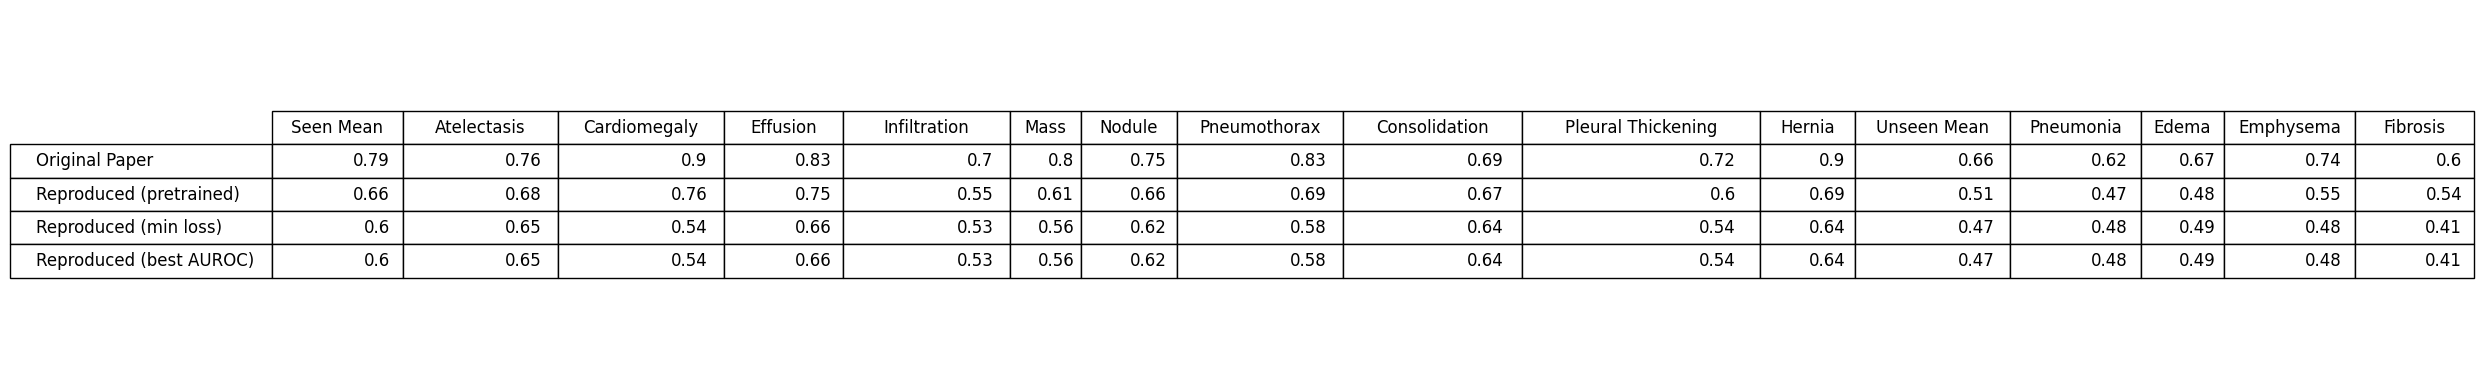

In [51]:
df = pd.DataFrame(results).T.round(2)

fig, ax = plt.subplots()
ax.axis('off')

tbl = table(ax, df, loc='center', colWidths=[ 0.02 * (len(col)+2) for col in df.columns.tolist() ])
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 2)

plt.show()